First import the modules we need:

In [1]:
import trajectory, trajectory.post, trajectory.aero, csv
import numpy as np

#To make the plots interactive:
#%matplotlib notebook

To run an aerodynamic simulation, we must have already run a trajectory simulation and saved the output to a .JSON. We will now import that JSON:

In [2]:
trajectory_data = trajectory.from_json("output.json")

We need the original rocket that was used for the trajectory simulation, so we'll import it:

In [3]:
from martlet4 import martlet4

Now we can start setting up an aerodynamic heating simulation. First we must define the nosecone shape, by creating a TangentOgive object:

In [4]:
tangent_ogive = trajectory.post.TangentOgive(xprime = 73.7e-2, yprime = (19.7e-2)/2)

'xprime' is the length of the nosecone, and 'yprime' is the radius. See Fig 2. of https://arc.aiaa.org/doi/pdf/10.2514/3.62081 for a diagram.

We can now set up the aerodynamic heating simulation, and run a step:

In [5]:
analysis = trajectory.post.HeatTransfer(tangent_ogive, trajectory_data, martlet4)
analysis.step(print_style="metric")


SUBCRIPTS:
0 or STAG  : At the stagnation point for a hemispherical nose
REF        : At 'reference' enthalpy and local pressure - I think this is like an average-ish boundary layer enthalpy
REC        : At 'recovery' enthalpy and local pressure - I believe this is the wall enthalpy at which no heat transfer takes place
W          : At the wall temperature and local pressure
INF        : Freestream (i.e. atmospheric) property
LAM        : With a laminar boundary layer
TURB       : With a turbulent boundary layer

FREE STREAM CONDITIONS
ALT =000.00 km    TINF=288.15 K    PINF=101.33 kPa    RHOINF=001.23 kg/m^3
VINF=000.00 m/s   MINF=000.00

Subsonic flow, skipping step number 0


We can run a set amount of steps using HeatTransfer.run(number of iterations). We'll then export the data to a .JSON file, using HeatTransfer.to_json(directory)

In [ ]:
analysis.run(iterations = 300, print_style="minimal")
analysis.to_json("martlet4_heating.json")

If you alreayd have data, and don't want to wait for the simulation to run, you can import it, as shown below:

In [6]:
analysis.from_json("martlet4_heating.json")

Now we'll make some nice plots of the data.

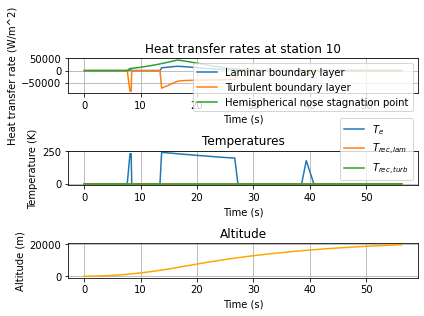

In [7]:
analysis.plot_station(station_number = 10, imax = 300)

 D:\OneDrive - University Of Cambridge\Cambridge\CUSF\6DOF-Trajectory-Simulation\trajectory\post.py:850: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


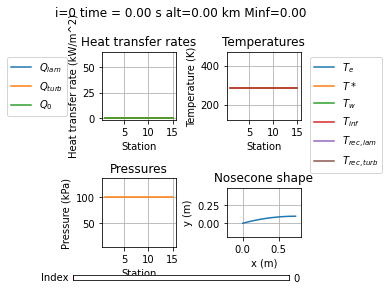

 D:\OneDrive - University Of Cambridge\Cambridge\CUSF\6DOF-Trajectory-Simulation\trajectory\post.py:946: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


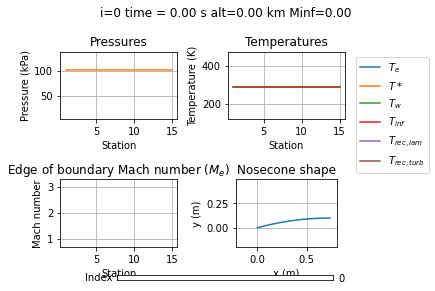

In [9]:
analysis.plot_heat_transfer()
analysis.plot_fluid_properties()